In [1]:
import torch
import torchvision
import iecdt_lab
import train_autoencoder
from torch import nn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tqdm
import numpy as np

In [2]:
TILES_FILE = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_numpy"
TEST_METADATA = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_test.csv"
TILES_STATISTICS = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz"

# The Autoencoder

## Autoencoder Structure and Training Algorithm

Autoencoder is currently symmetric, with the decoder being structured inversely to the encoder:

The encoder has:

3 convolution layers (with relu activation functions) and 1 fully connected linear layer (no activation function afterwards).

Convolution all have:
* kernel size = 3
* stride = 2
* padding = 1

First, second, and third convolutions output a batch size of 32, 64, and 128, respectively.

Fully connected linear layer compresses flattened output of previous layer into an array of size `latent_dim`. (Default is 128)

## Autoencoder Performance

In [ ]:
#Specify device

device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

# Load autoencoder

#Specify which model here
path_to_model = "logs/test/runs/2026-02-09_16-09-40/model.pth"

model = iecdt_lab.autoencoder.CNNAutoencoder(latent_dim=128)
model.load_state_dict(torch.load(path_to_model,map_location=device))
model.to(device)
model.eval()

# Compute Autoencoder Embeddings

'/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz'

In [5]:
data_stats = np.load(TILES_STATISTICS)
data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=data_stats["rgb_mean"], std=data_stats["rgb_std"]
        ),
    ]
)
test_ds = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
    transform=data_transforms,
)
test_data_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=True,
    num_workers=16,
)

Remove the last layer of the ResNet so the model outputs the embeddings before the final layer.

In [6]:
embedding_model = torch.nn.Sequential(*list(model.children())[:-1])
embedding_model.eval()

Sequential(
  (0): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=131072, out_features=128, bias=True)
  )
)

Compute the actual embeddings for all of the test dataset. This cell will take a couple of minutes to run!

In [7]:
embeddings = []
for batch, labels in tqdm.tqdm(test_data_loader):
    with torch.no_grad():
        embeddings.append(embedding_model(batch).numpy())
embeddings = np.concatenate(embeddings, axis=0)
embeddings = embeddings.reshape(embeddings.shape[0], -1)

100%|██████████| 58/58 [00:31<00:00,  1.86it/s]


In [8]:
embeddings.shape

(3696, 128)

# Cluster the Embeddings

In [9]:
def plot_cluster_tiles(cluster_labels, tile_dataset, num_samples=5) -> plt.Figure:
    """Plot the clusters of the test tiles. Each column is a cluster."""
    num_clusters = len(np.unique(cluster_labels))
    fig, axs = plt.subplots(
        num_samples, num_clusters, figsize=(num_clusters * 2, num_samples * 2)
    )
    for i in range(num_clusters):
        cluster_ixs = np.where(cluster_labels == i)[0]
        for j in range(num_samples):
            if j < len(cluster_ixs):
                tile, _ = tile_dataset[cluster_ixs[j]]
                axs[j, i].imshow(tile)
            axs[j, i].axis("off")

        axs[0, i].set_title(f"Cluster {i}")

    fig.tight_layout()
    return fig

def plot_clusters(cluster_labels, pca_embeddings) -> plt.Figure:
    """Plot the clusters in the PCA space."""
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in np.unique(cluster_labels):
        cluster_ixs = np.where(cluster_labels == i)[0]
        ax.scatter(
            pca_embeddings[cluster_ixs, 0],
            pca_embeddings[cluster_ixs, 1],
            label=f"Cluster {i}",
        )
    ax.legend()
    return fig

To get some understanding of how the embedding space is structured we will first reduce the embedding dimensionality using principal component analysis (PCA) and then cluster using KMeans. Feel free to experiment with different dimensionality reduction methods and clustering algorithms!

In [10]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_embeddings)
cluster_labels = kmeans.predict(pca_embeddings)

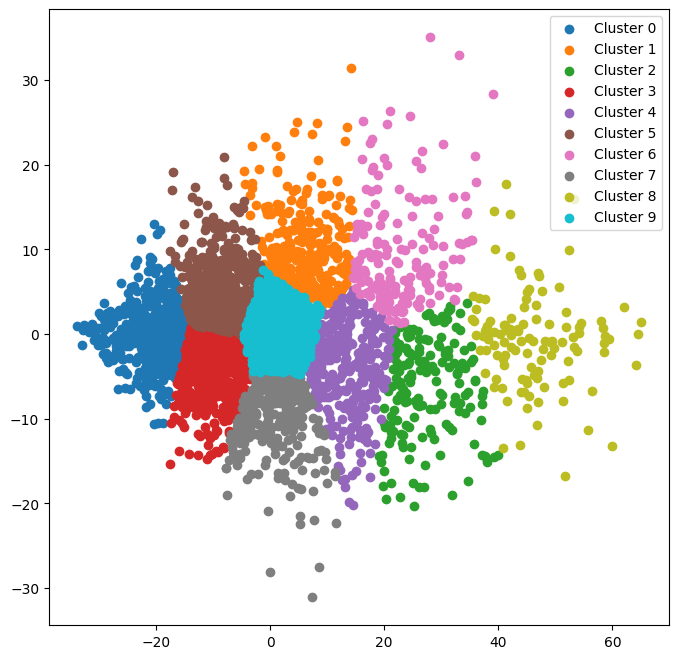

In [11]:
_ = plot_clusters(cluster_labels, pca_embeddings)

In [12]:
test_ds_no_transform = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
)

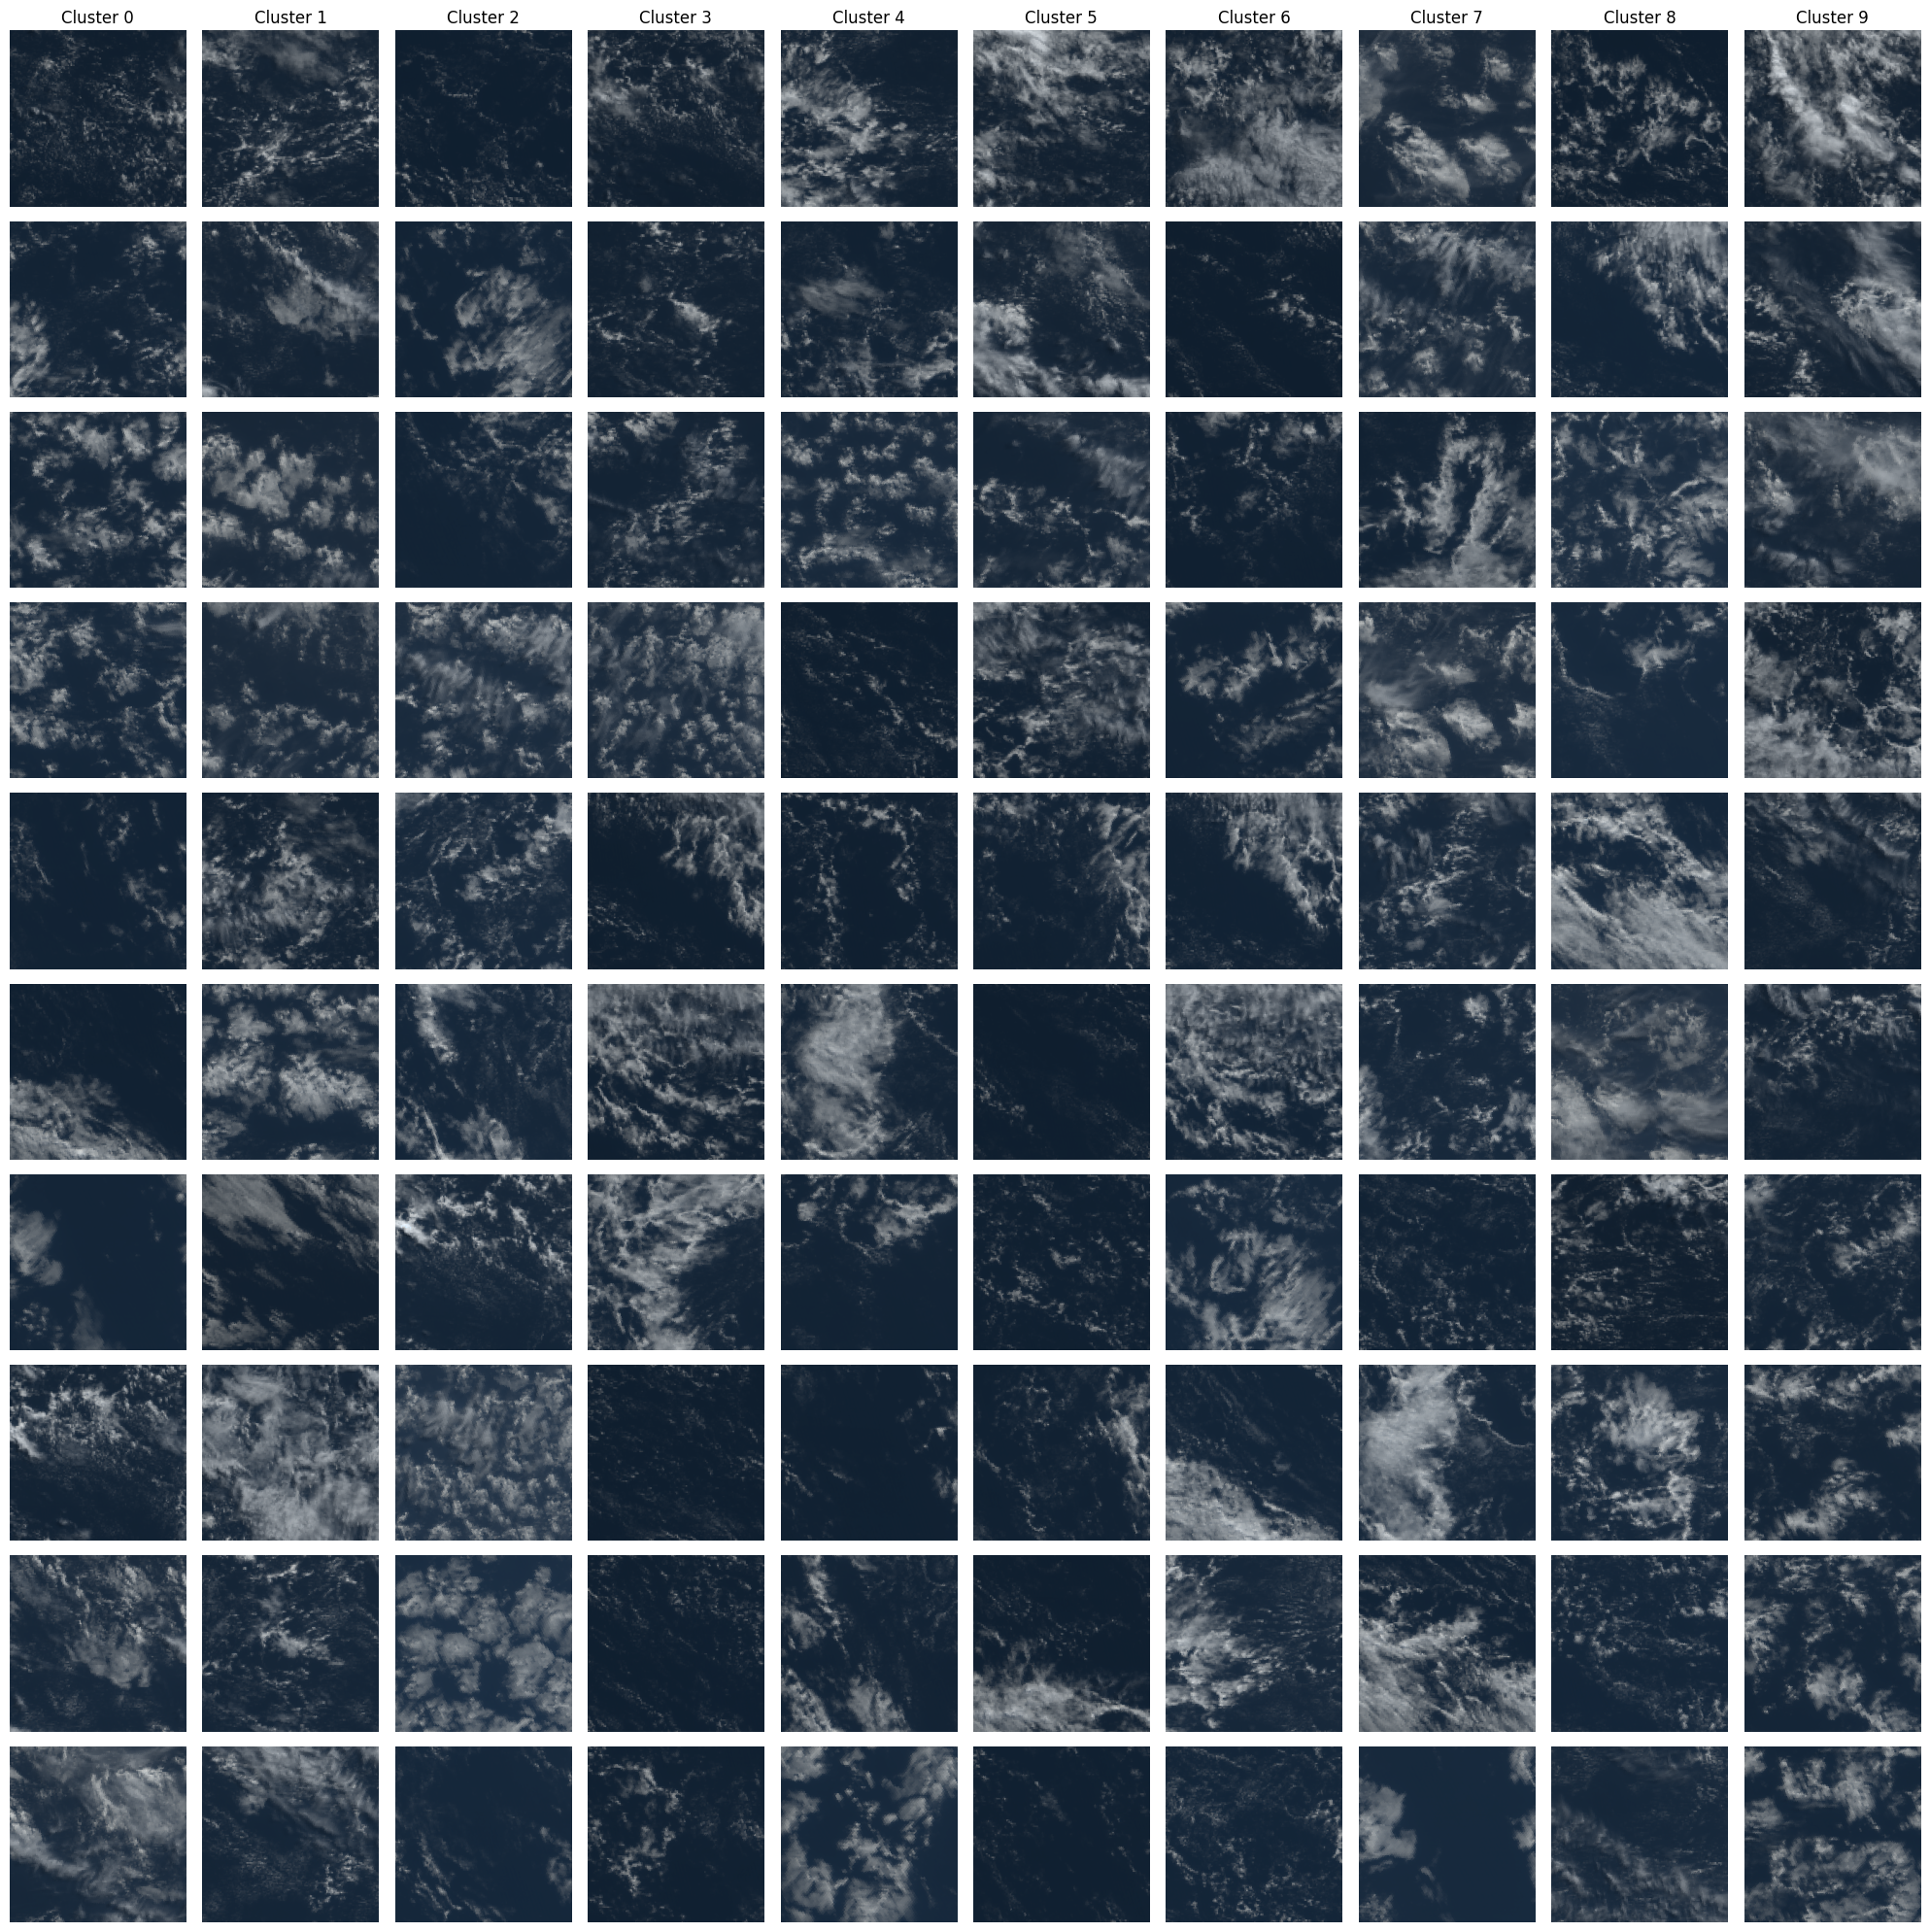

In [13]:
_ = plot_cluster_tiles(cluster_labels, test_ds_no_transform, num_samples=10)

# Compute ResNet Embeddings

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid(),  # Ensure that output lies between 0 and 1.
)
# If you want to load a model that you have trained use:
path_to_model = "logs/test/runs/2026-02-09_15-46-42/model.pth"
model.load_state_dict(torch.load(path_to_model,map_location=device))
model.eval()

/tmp/ipykernel_1373816/4246985623.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_model,map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
data_stats = np.load(TILES_STATISTICS)
data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=data_stats["rgb_mean"], std=data_stats["rgb_std"]
        ),
    ]
)
test_ds = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
    transform=data_transforms,
)
test_data_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=True,
    num_workers=16,
)

Remove the last layer of the ResNet so the model outputs the embeddings before the final layer.

In [14]:
embedding_model = torch.nn.Sequential(*list(model.children())[:-1])
embedding_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Compute the actual embeddings for all of the test dataset. This cell will take a couple of minutes to run!

In [15]:
embeddings = []
for batch, labels in tqdm.tqdm(test_data_loader):
    with torch.no_grad():
        embeddings.append(embedding_model(batch).numpy())
embeddings = np.concatenate(embeddings, axis=0)
embeddings = embeddings.reshape(embeddings.shape[0], -1)

100%|██████████| 58/58 [01:30<00:00,  1.57s/it]


In [16]:
embeddings.shape

(3696, 512)

# Cluster the Embeddings

To get some understanding of how the embedding space is structured we will first reduce the embedding dimensionality using principal component analysis (PCA) and then cluster using KMeans. Feel free to experiment with different dimensionality reduction methods and clustering algorithms!

In [26]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_embeddings)
cluster_labels = kmeans.predict(pca_embeddings)

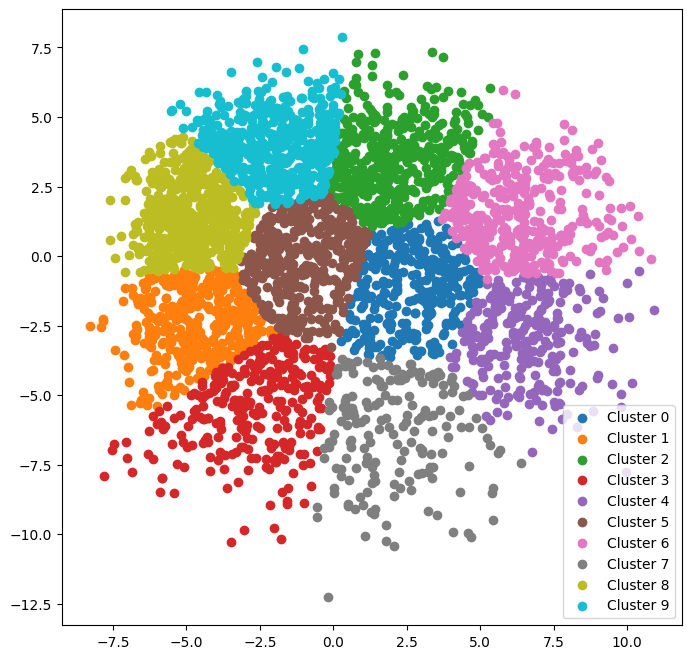

In [27]:
_ = plot_clusters(cluster_labels, pca_embeddings)

In [28]:
test_ds_no_transform = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
)

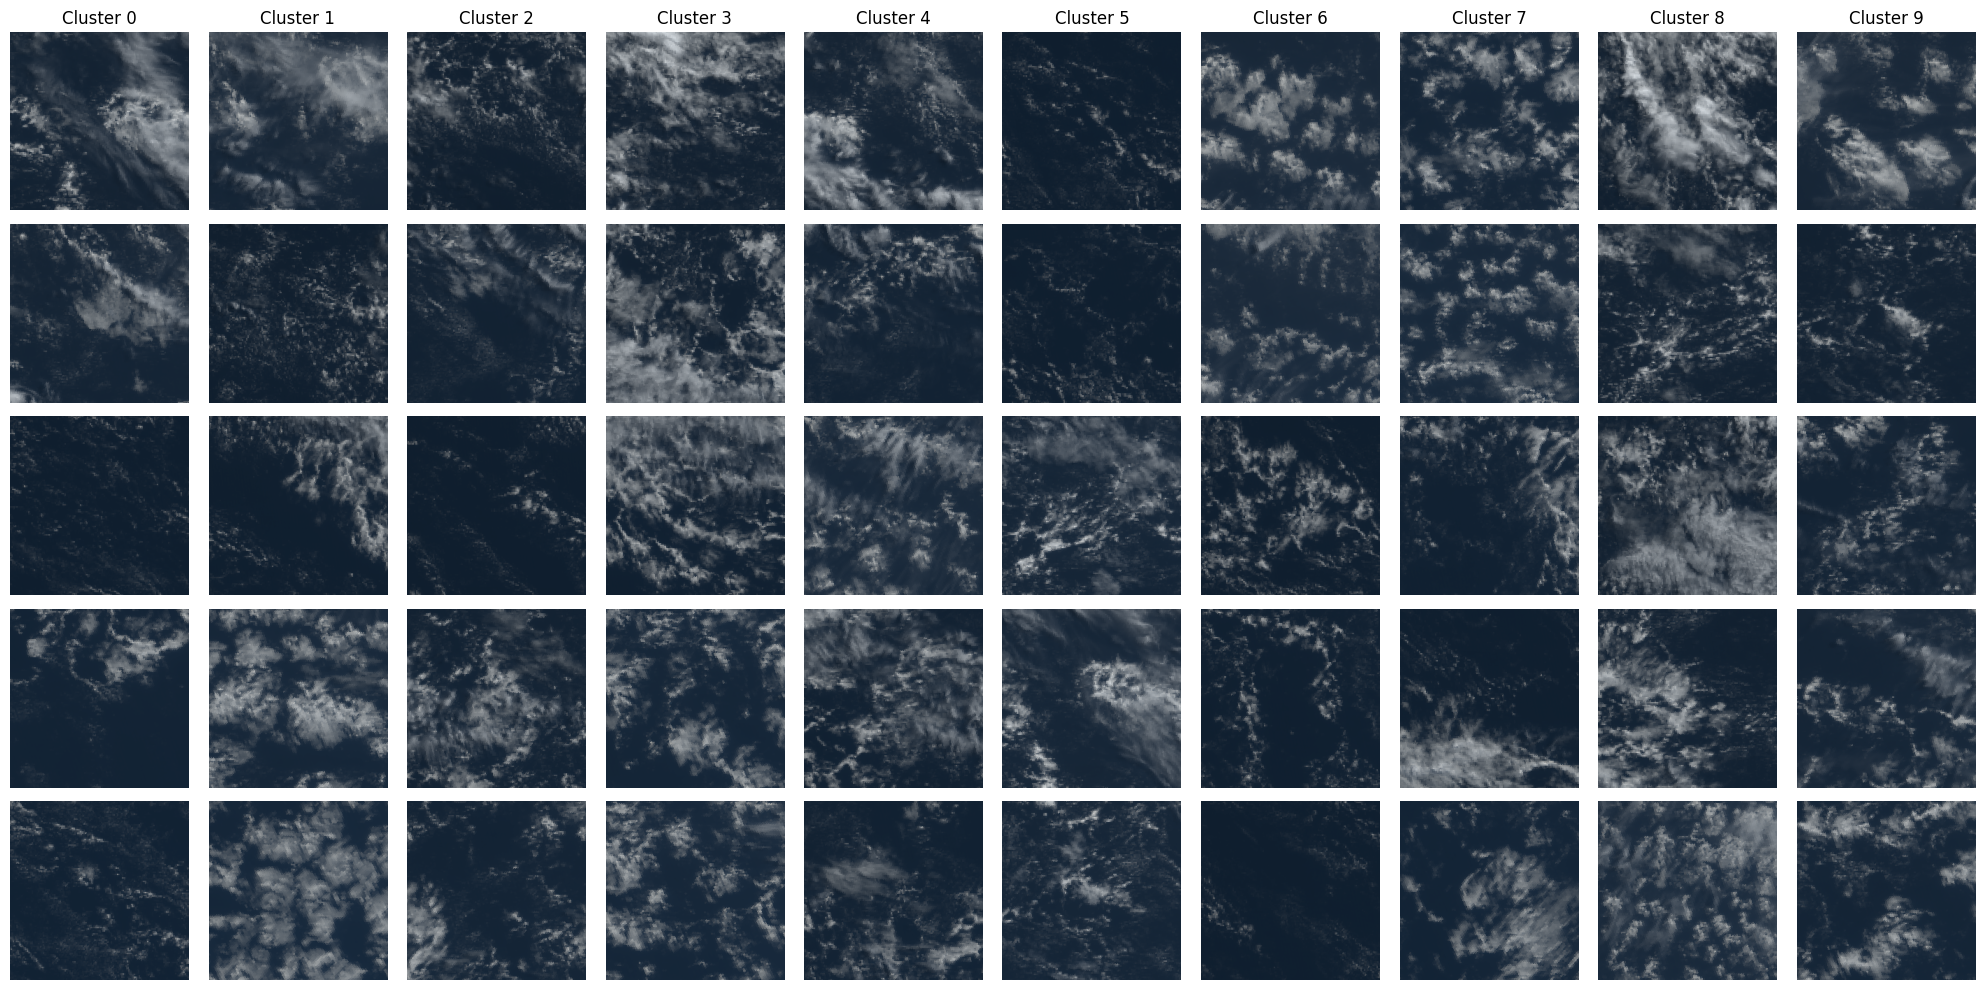

In [29]:
_ = plot_cluster_tiles(cluster_labels, test_ds_no_transform, num_samples=5)